#  setup

In [1]:
%%file locate_file.py

def locate_file() : 
    working_directory = ''
    for element in __file__.split('/')[:-1] :
        working_directory += element + '/'
    return working_directory

Overwriting locate_file.py


In [2]:
import locate_file
working_directory = locate_file.locate_file()

import os
import matplotlib.pyplot as plt
import matplotlib
import numpy

%matplotlib inline
os.chdir(working_directory)

# convolution.c

In [3]:
%%file convolution.c
#import <math.h>
#include <stdio.h>

void convolution(int *array, int rows, int columns) {
    int i,j;
    int return_array[rows][columns];
    for(i=0;i<rows;i++){ 
        for(j=0;j<columns;j++) {
            *(array+(i*columns)+j) = 255 - *(array+(i*columns)+j);
        }
    }
}

Overwriting convolution.c


# compilation

In [4]:
os.system('cd ' + working_directory)
!clang -c convolution.c
!clang -o libconvolution.so -shared convolution.o
!file libconvolution.so

libconvolution.so: Mach-O 64-bit dynamically linked shared library x86_64


# python wrapper module

In [5]:
%%file _convolution.py
import ctypes
import numpy
import locate_file
working_directory = locate_file.locate_file()

_convolution_ = ctypes.cdll.LoadLibrary(working_directory + 'libconvolution.so')

class image_type() : 
    
    def from_param(self,param) : 
        typename = type(param).__name__
        if hasattr(self,'from_'+typename) : 
            return getattr(self,'from_'+typename)(param)
        elif isinstance(param,ctypes.Array) : 
            
            return param
        else : 
            raise TypeError('type %s not supported' %typename) 
    
    def from_ndarray(self,param) : 
        c_array = numpy.ascontiguousarray(param)
        pointer = c_array.ctypes
        return pointer
    
    def from_list(self,param) : 
        return self.from_ndarray(param)
    
    def from_tuple(self,param) : 
        return self.from_ndarray(param)
    
image_type_ = image_type()
    
_convolution_.convolution.argtypes = [image_type_,ctypes.c_int,ctypes.c_int]
_convolution_.convolution.restype = ctypes.c_void_p

def convolution(array) : 
    c_array = numpy.ascontiguousarray(array,dtype=numpy.uint32)
    _convolution_.convolution(c_array,len(array),len(array[0]))
    return c_array

Overwriting _convolution.py


**numpy.ascontiguousarray** returns a contiguous array in memory (C order)

# testing

### class image processing

In [6]:
class image_processing() : 
    
    def __init__(self) : 
        pass
    
    def convolution(self,image,kernel) : 
        
        scaling_factor = kernel[0]
        kernel = kernel[1]
        image_width = len(image[0])
        image_height = len(image)
        kernel_width = len(kernel[0])
        kernel_height = len(kernel)

        return_image = []

        def element_wise_matrix_multiplication(matrix1,matrix2,scaling_factor=1) :
            return_value = 0
            for m1_row,m2_row in zip(matrix1,matrix2) :
                for m1_pixel,m2_pixel in zip(m1_row,m2_row) :
                    return_value += int(m1_pixel)*int(m2_pixel)
            return numpy.uint8(return_value/scaling_factor)
                
        for row in range(image_height - kernel_height + 1) :
            return_image.append([])
            for pixel in range(image_width - kernel_width + 1) :
                image_slice = [[image[i,j] for j in range(pixel,pixel + kernel_width)]\
                               for i in range(row,row + kernel_height)]
                #print(image_slice)
                return_image[-1].append(element_wise_matrix_multiplication(image_slice,kernel,scaling_factor))
        return numpy.array(return_image)
    
    def rgb_to_greyscale(self,image) : 
        return_image = []
        for row in image : 
            return_image.append([])
            for pixel in row : 
                try : 
                    [r,g,b,s] = pixel
                except ValueError : 
                    [r,g,b] = pixel
                return_image[-1].append(numpy.uint8((int(r)+int(g)+int(b))/3))
        return numpy.array(return_image)
    
    def add_images(self,image1,image2) :
        return_array = []
        for row1,row2 in zip(image1,image2) : 
            return_array.append([])
            for pixel1,pixel2 in zip(row1,row2) :
                return_array[-1].append(numpy.uint8((int(pixel1))|(int(pixel2))))
        return numpy.array(return_array)

### decorator *time_this_function*

In [7]:
def time_this_function(function) : 
    try : 
        time
    except : 
        import time
    
    def wrapper_function(*args,**kwargs) : 
        start_time = time.time()
        return_value = function(*args,**kwargs)
        elapsed_time = (time.time() - start_time)*1000
        print('elapsed_time = ' + str(elapsed_time),end=' ms\n')
        return return_value
    return wrapper_function

In [8]:
import _convolution

@time_this_function 
def c_test(array) : 
    return _convolution.convolution(array)

@time_this_function
def python_test(array) : 
    return_array = []
    for element in array :
        return_array.append([])
        for number in element : 
            return_array[-1].append(numpy.uint8(255-number))
    return numpy.array(return_array)

In [9]:
image = plt.imread('sample_image_3.png')

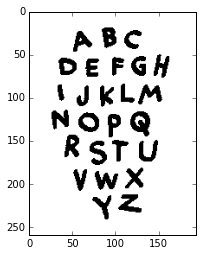

In [10]:
image_processing_ = image_processing()
image = image_processing_.rgb_to_greyscale(image)
plt.imshow(image,cmap=plt.get_cmap('gray'))

elapsed_time = 0.5218982696533203 ms


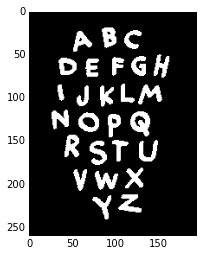

In [11]:
c_image = c_test(image)
plt.imshow(c_image,cmap=plt.get_cmap('gray'))